# 📊 CartPole Analysis & Comparison Notebook
This notebook compares PPO vs A2C and Solver vs Fuzzer
personas using evaluation CSVs from `logs/cartpole/eval/`.
### Outputs:
✅ Summary table of average metrics
✅ Bar charts for reward, steps, unique_states, crash rate
✅ Histograms of reward & steps per run
✅ (Optional) Learning curves from TensorBoard logs

All generated plots and summary CSVs are saved under: plots/cartpole/

In [6]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# EVAL_DIR = "logs/cartpole/eval"
# PLOT_DIR = "plots/cartpole"
# os.makedirs(PLOT_DIR, exist_ok=True)

import os

# Make sure paths are correct no matter where the notebook runs
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if not os.path.exists(os.path.join(ROOT_DIR, "logs/cartpole/eval")):
    # fallback: if we're already in project root, don't go up
    ROOT_DIR = os.getcwd()

print("📁 Current working directory:", os.getcwd())
print("🔍 Using root directory:", ROOT_DIR)

EVAL_DIR = os.path.join(ROOT_DIR, "logs/cartpole/eval")
PLOT_DIR = os.path.join(ROOT_DIR, "plots/cartpole")
os.makedirs(PLOT_DIR, exist_ok=True)

print("Looking for CSVs in:", EVAL_DIR)


📁 Current working directory: d:\4th year\fallSem\Topics in CS I\sokoban-assgn\notebooks
🔍 Using root directory: d:\4th year\fallSem\Topics in CS I\sokoban-assgn
Looking for CSVs in: d:\4th year\fallSem\Topics in CS I\sokoban-assgn\logs/cartpole/eval


In [11]:
# =====================================================
# 🔍 Step 1 — Load all evaluation CSVs
# =====================================================
# Each file is expected to follow the naming format:
#   {algo}_cartpole_{persona}_seed{seed}.csv
# Example:
#   ppo_cartpole_solver_seed7.csv
#   a2c_cartpole_fuzzer_seed7.csv

RUN_RE = re.compile(r"(?P<algo>ppo|a2c)_cartpole_(?P<persona>solver|fuzzer)_seed(?P<seed>\d+)\.csv", re.I)

def parse_metadata(filename):
    """Extract algo, persona, and seed info from CSV name."""
    name = os.path.basename(filename)
    m = RUN_RE.match(name)
    if not m:
        return None
    meta = m.groupdict()
    meta["seed"] = int(meta["seed"])
    return meta

csv_files = sorted(glob.glob(os.path.join(EVAL_DIR, "*.csv")))
if not csv_files:
    raise FileNotFoundError(f"No CSVs found in {EVAL_DIR}. Run src/eval_cp.py first.")

frames = []
for f in csv_files:
    meta = parse_metadata(f)
    if meta is None:
        continue
    df = pd.read_csv(f)
    df["algo"] = meta["algo"].lower()
    df["persona"] = meta["persona"].lower()
    df["seed"] = meta["seed"]
    df["run_id"] = f"{meta['algo']}_{meta['persona']}_seed{meta['seed']}"
    # Infer crash: episode ends before 500 steps
    df["crash"] = (df["steps"] < 500).astype(int)
    frames.append(df)

data = pd.concat(frames, ignore_index=True)
print(f"Loaded {len(frames)} runs with {len(data)} total episodes.")
display(data.head())


Loaded 4 runs with 400 total episodes.


,episode,steps,reward,unique_states,final_angle,algo,persona,seed,run_id,crash
0,1,121,11.43,104,-0.130756,a2c,fuzzer,7,a2c_fuzzer_seed7,1
1,2,117,11.03,100,-0.136202,a2c,fuzzer,7,a2c_fuzzer_seed7,1
2,3,122,11.09,101,-0.137348,a2c,fuzzer,7,a2c_fuzzer_seed7,1
3,4,117,10.81,98,-0.131466,a2c,fuzzer,7,a2c_fuzzer_seed7,1
4,5,118,11.13,101,-0.122789,a2c,fuzzer,7,a2c_fuzzer_seed7,1


In [12]:
# =====================================================
# 📈 Step 2 — Compute summary metrics
# =====================================================

summary = data.groupby(["algo", "persona"]).agg(
    episodes=("episode", "count"),
    reward_mean=("reward", "mean"),
    reward_std=("reward", "std"),
    steps_mean=("steps", "mean"),
    steps_std=("steps", "std"),
    unique_states_mean=("unique_states", "mean"),
    unique_states_std=("unique_states", "std"),
    crash_rate=("crash", "mean")
).reset_index()

# Pretty display with mean ± std
summary["Reward (mean±std)"] = summary["reward_mean"].round(2).astype(str) + " ± " + summary["reward_std"].round(2).astype(str)
summary["Steps (mean±std)"]  = summary["steps_mean"].round(1).astype(str) + " ± " + summary["steps_std"].round(1).astype(str)
summary["Unique (mean±std)"] = summary["unique_states_mean"].round(1).astype(str) + " ± " + summary["unique_states_std"].round(1).astype(str)
summary["Crash Rate (%)"] = (summary["crash_rate"] * 100).round(1)

display(summary)

# Save numeric version
summary_out = os.path.join(PLOT_DIR, "summary_metrics.csv")
summary.to_csv(summary_out, index=False)
print(f"✅ Saved summary CSV → {summary_out}")


,algo,persona,episodes,reward_mean,reward_std,steps_mean,steps_std,unique_states_mean,unique_states_std,crash_rate,Reward (mean±std),Steps (mean±std),Unique (mean±std),Crash Rate (%)
0,a2c,fuzzer,100,10.904400,0.390902,113.65,4.135031,98.99,3.691363,1.00,10.9 ± 0.39,113.6 ± 4.1,99.0 ± 3.7,100.0
1,a2c,solver,100,653.353819,46.628816,493.33,18.823505,0.00,0.000000,0.14,653.35 ± 46.63,493.3 ± 18.8,0.0 ± 0.0,14.0
2,ppo,fuzzer,100,1.163300,0.856556,500.00,0.000000,56.03,7.786877,0.00,1.16 ± 0.86,500.0 ± 0.0,56.0 ± 7.8,0.0
3,ppo,solver,100,671.928480,66.684399,491.36,29.779160,0.00,0.000000,0.12,671.93 ± 66.68,491.4 ± 29.8,0.0 ± 0.0,12.0


✅ Saved summary CSV → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\summary_metrics.csv


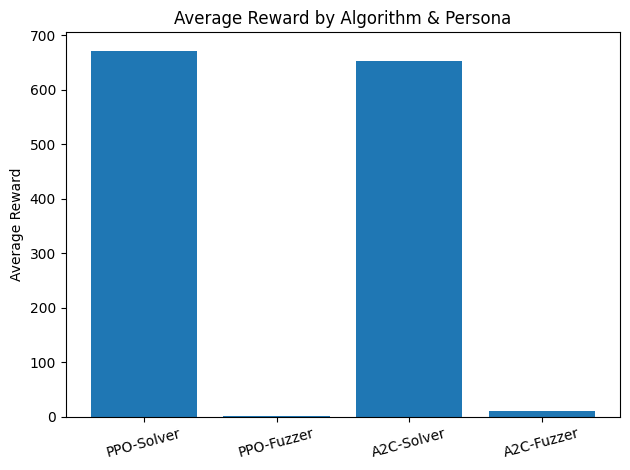

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\avg_reward_by_algo_persona.png


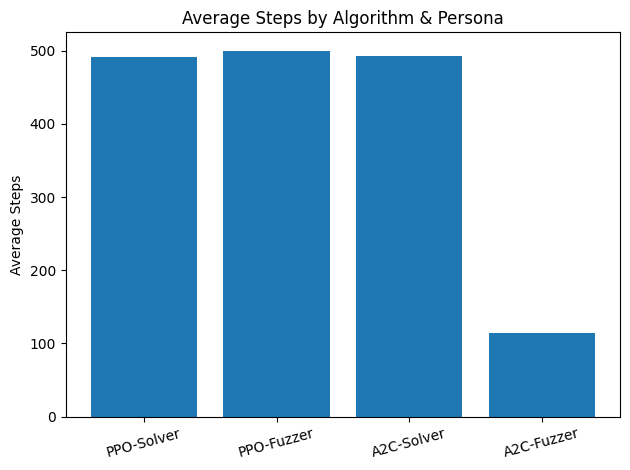

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\avg_steps_by_algo_persona.png


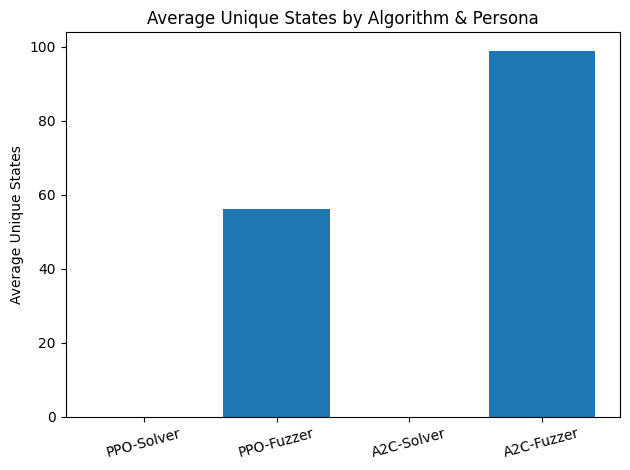

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\avg_unique_states_by_algo_persona.png


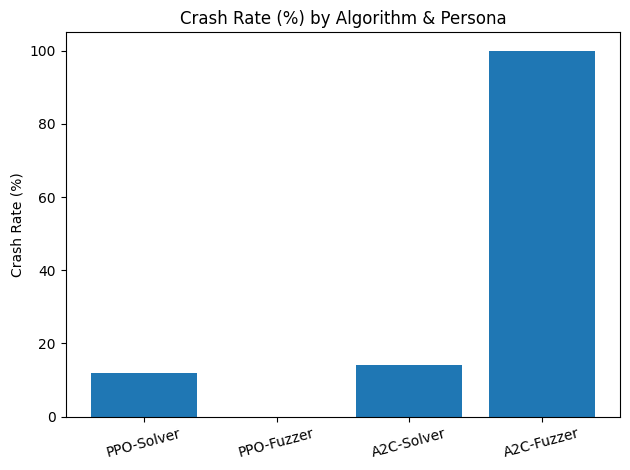

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\crash_rate_by_algo_persona.png


In [14]:
# =====================================================
# 📊 Step 3 — Bar charts for key metrics
# =====================================================

def bar_chart(metric, ylabel, filename, scale=1.0):
    """Plot and save a bar chart comparing (algo, persona) pairs."""
    fig = plt.figure()
    g = data.groupby(["algo", "persona"])[metric].mean().reset_index()
    # Sort to a stable order
    order = [("ppo", "solver"), ("ppo", "fuzzer"), ("a2c", "solver"), ("a2c", "fuzzer")]
    g["key"] = list(zip(g["algo"], g["persona"]))
    g = g.set_index("key").reindex(order).reset_index()
    labels = [f"{a.upper()}-{p.title()}" for a, p in g["key"]]
    values = g[metric] * scale
    plt.bar(labels, values)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} by Algorithm & Persona")
    plt.xticks(rotation=15)
    plt.tight_layout()
    out_path = os.path.join(PLOT_DIR, filename)
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"📁 Saved → {out_path}")

# Bar charts
bar_chart("reward", "Average Reward", "avg_reward_by_algo_persona.png")
bar_chart("steps", "Average Steps", "avg_steps_by_algo_persona.png")
bar_chart("unique_states", "Average Unique States", "avg_unique_states_by_algo_persona.png")
bar_chart("crash", "Crash Rate (%)", "crash_rate_by_algo_persona.png", scale=100)


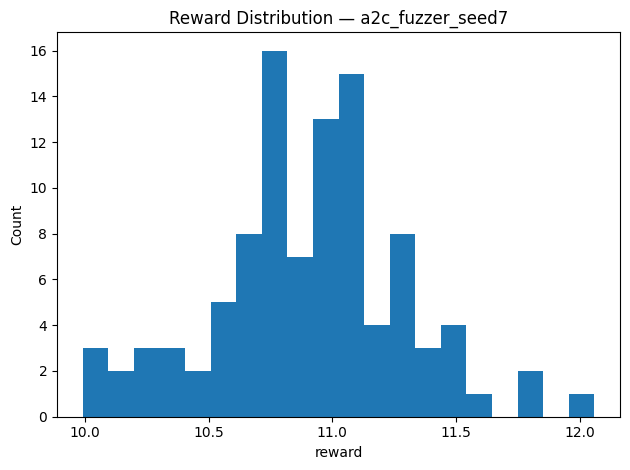

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\reward_hist_a2c_fuzzer_seed7.png


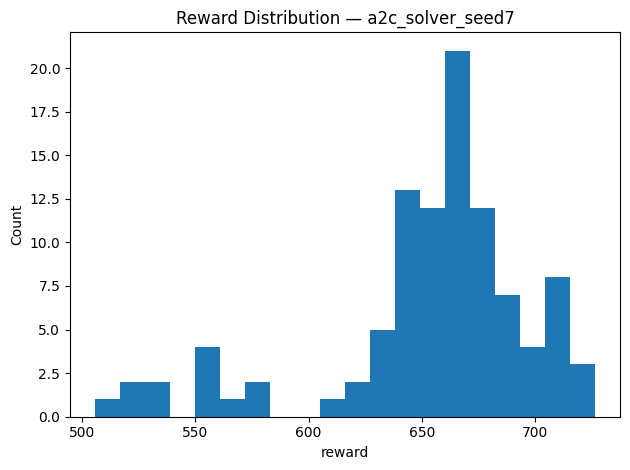

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\reward_hist_a2c_solver_seed7.png


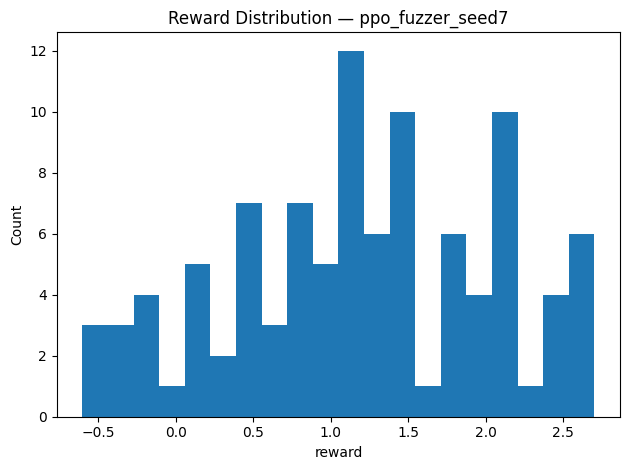

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\reward_hist_ppo_fuzzer_seed7.png


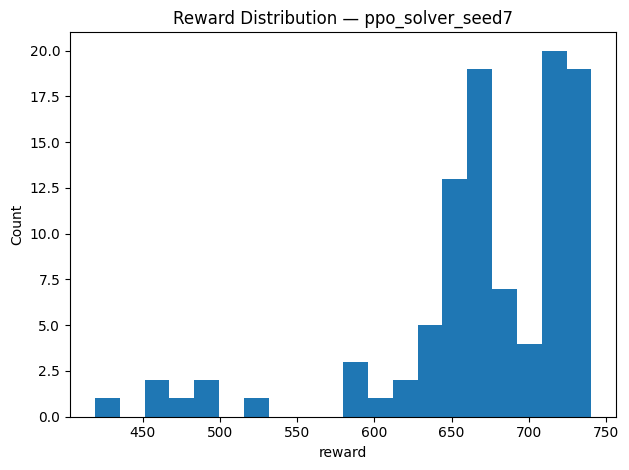

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\reward_hist_ppo_solver_seed7.png


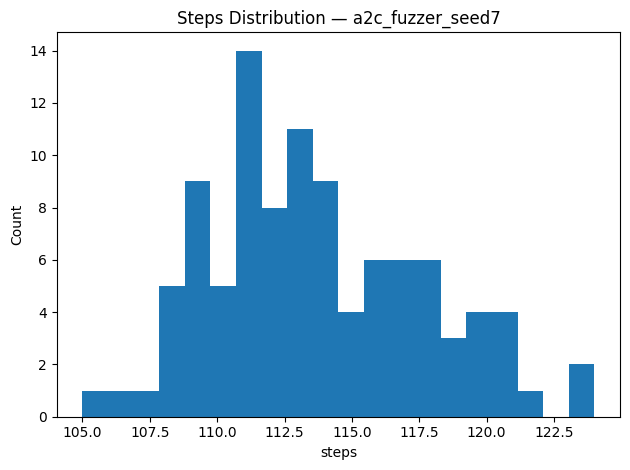

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\steps_hist_a2c_fuzzer_seed7.png


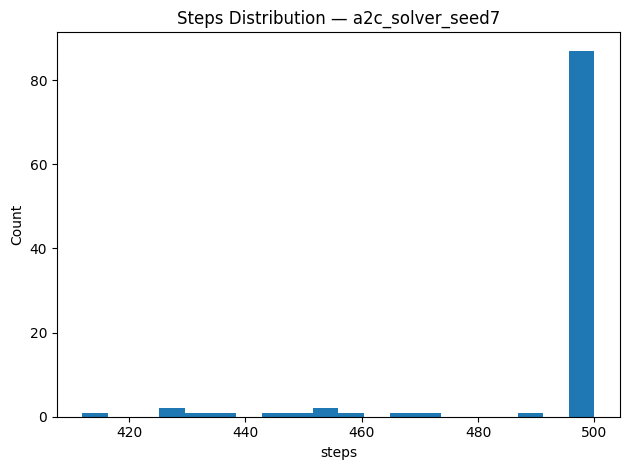

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\steps_hist_a2c_solver_seed7.png


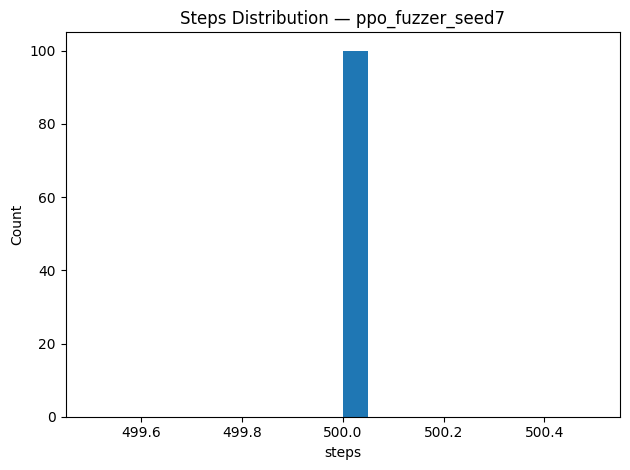

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\steps_hist_ppo_fuzzer_seed7.png


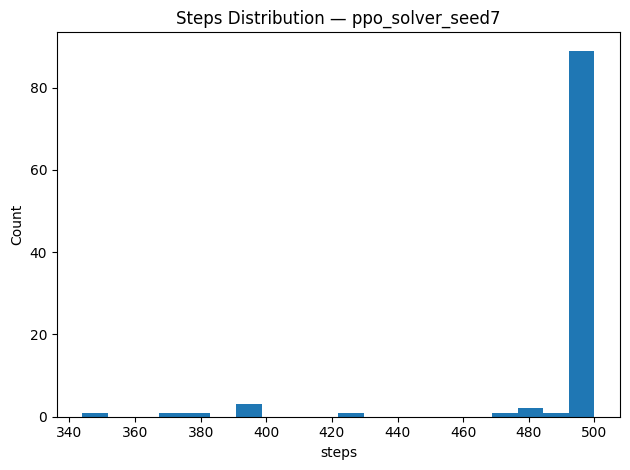

📁 Saved → d:\4th year\fallSem\Topics in CS I\sokoban-assgn\plots/cartpole\steps_hist_ppo_solver_seed7.png


In [15]:
# =====================================================
# 🧩 Step 4 — Reward & Steps Distributions per Run
# =====================================================

def histograms_per_run(metric, prefix):
    """Generate one histogram per run."""
    for run_id, df in data.groupby("run_id"):
        fig = plt.figure()
        plt.hist(df[metric], bins=20)
        plt.xlabel(metric)
        plt.ylabel("Count")
        plt.title(f"{metric.title()} Distribution — {run_id}")
        plt.tight_layout()
        out_path = os.path.join(PLOT_DIR, f"{prefix}_{run_id}.png")
        plt.savefig(out_path, dpi=150)
        plt.show()
        print(f"📁 Saved → {out_path}")

histograms_per_run("reward", "reward_hist")
histograms_per_run("steps", "steps_hist")


In [17]:
# =====================================================
# 📉 Step 5 — (Optional) Learning Curves from TensorBoard
# =====================================================
# This section reads TensorBoard event files and plots rollout/ep_rew_mean
# for each run. It will gracefully skip if TB logs are missing.
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if not os.path.exists(os.path.join(ROOT_DIR, "logs/cartpole/etensorboard")):
    # fallback: if we're already in project root, don't go up
    ROOT_DIR = os.getcwd()

try:
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
    def plot_tb_curve(run_name, tb_dir=ROOT_DIR + "/logs/cartpole/etensorboard"):
        run_path = os.path.join(tb_dir, run_name)
        if not os.path.isdir(run_path):
            print(f"⚠️ No TensorBoard logs for {run_name}")
            return
        ea = EventAccumulator(run_path)
        ea.Reload()
        if "rollout/ep_rew_mean" not in ea.Tags().get("scalars", []):
            print(f"⚠️ No 'rollout/ep_rew_mean' in {run_name}")
            return
        events = ea.Scalars("rollout/ep_rew_mean")
        steps = [e.step for e in events]
        vals = [e.value for e in events]
        fig = plt.figure()
        plt.plot(steps, vals)
        plt.xlabel("Timesteps")
        plt.ylabel("Mean Episode Reward")
        plt.title(f"Learning Curve — {run_name}")
        plt.tight_layout()
        out_path = os.path.join(PLOT_DIR, f"learning_curve_{run_name}.png")
        plt.savefig(out_path, dpi=150)
        plt.show()
        print(f"📁 Saved → {out_path}")

    # Try all 4 combinations
    runs = [
        "ppo_cartpole_solver_seed7",
        "ppo_cartpole_fuzzer_seed7",
        "a2c_cartpole_solver_seed7",
        "a2c_cartpole_fuzzer_seed7",
    ]
    for r in runs:
        plot_tb_curve(r)
except Exception as e:
    print("TensorBoard not installed or no logs found — skipping learning curves.")
    print(e)

⚠️ No TensorBoard logs for ppo_cartpole_solver_seed7
⚠️ No TensorBoard logs for ppo_cartpole_fuzzer_seed7
⚠️ No TensorBoard logs for a2c_cartpole_solver_seed7
⚠️ No TensorBoard logs for a2c_cartpole_fuzzer_seed7
